## This notebook is meant to be run from COLAB

In [0]:
# Downgrade to TF 1.13.1
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 1.4MB/s 
     |████████████████████████████████| 3.2MB 27.5MB/s 
     |████████████████████████████████| 368kB 51.0MB/s 
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

import pickle
import random
from sklearn.model_selection import train_test_split


##Mounting GDrive

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive/My\ Drive/Colab\ Notebooks/IDRID')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# cd 'My Drive'
cd 'drive/My Drive/Colab_Notebooks/IDRID/'

/content/drive/My Drive/Colab_Notebooks/IDRID


In [0]:
ls -l

total 848071
-rw------- 1 root root     43273 Jul  9 16:41 angel_blindness_detection.ipynb
-rw------- 1 root root    422616 Jul 23 00:42 cnn1_augmented_extra.h5
-rw------- 1 root root    422768 Jul 23 01:51 cnn1_augmented_extra_v2.h5
-rw------- 1 root root    645704 Jul 23 02:10 cnn1_augmented_extra_v3.h5
-rw------- 1 root root    440672 Jul 24 16:58 cnn2_augmented_extra_seaborn_v1.h5
-rw------- 1 root root    645712 Jul 23 21:45 cnn2_augmented_extra_v1.h5
-rw------- 1 root root    645704 Jul 24 17:47 cnn2_augmented_extra_v2.h5
-rw------- 1 root root   1444536 Jul 25 19:54 cnn3_model_augmented_7-24-2019_trained.h5
-rw------- 1 root root    646544 Jul 26 23:55 cnn3_model_augmented_7-25-2019_trained_v2.h5
-rw------- 1 root root   4845824 Jul 22 15:37 cnn_trained_augmented_256.h5
-rw------- 1 root root    645552 Jul 22 01:41 cnn_trained_augmented.h5
-rw------- 1 root root    170162 Jul 26 20:00 model.png
-rw------- 1 root root     25072 Jul  7 19:01 test.csv
-rw------- 1 root root     549

## Load image data from pickle file and store it in 'training_data' array

In [0]:
# pickle_in = open("training_data_brightness.pickle","rb")
# training_data_old = pickle.load(pickle_in)

pickle_in = open("training_data_new_merge.pickle","rb")
training_data = pickle.load(pickle_in)

## Create X_train, X_test, y_train, y_test
## This cell must be run each time the model will be trained

In [0]:
random.shuffle(training_data)

IMG_SIZE = 224

X = []
y = []

# This for loop reads data and creates X and y
for features,label in training_data:
    X.append(features)
    y.append(label)

    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y).reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)


## Specify h5 file name for traine model 

In [0]:
saved_h5 = 'cnn2_augmented_extra_7_29.h5'
# weight_dict = {0:0.4057, 1:1.9794, 2:0.7331, 3:3.7948, 4:2.4827}
weight_dict = {0:0.7173, 1:0.8087, 2:1.2961, 3:1.2146, 4:1.2902}

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.02,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.02,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

## Train the MODEL

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


X_train = X_train/255.0
y_train = to_categorical(y_train)
X_test = X_test/255.0
y_test = to_categorical(y_test)


# Here is the model
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(5))

# softmax is commonly used for classification of multiple categories
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])              


earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=0, mode='min')

# Input the name of the h5 file to be saved
mcp_save = ModelCheckpoint(saved_h5, save_best_only=True, monitor='val_loss', mode='min')



history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32), epochs=500, validation_data=(X_test, y_test), callbacks=[earlyStopping, mcp_save], class_weight= weight_dict)





Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
172/172 [==============================] - 16s 94ms/step - loss: 1.5985 - acc: 0.2623 - val_loss: 1.5317 - val_acc: 0.3652
Epoch 2/500
172/172 [==============================] - 12s 72ms/step - loss: 1.4100 - acc: 0.4251 - val_loss: 1.3687 - val_acc: 0.4496
Epoch 3/500
172/172 [==============================] - 12s 72ms/step - loss: 1.3288 - acc: 0.4693 - val_loss: 1.2727 - val_acc: 0.4866
Epoch 4/500
172/172 [==============================] - 13s 73ms/step - loss: 1.2781 - acc: 0.4980 - val_loss: 1.1921 - val_acc: 0.5463
Epoch 5/500
172/172 [==============================] - 13s 73ms/step - loss: 1.2154 - acc: 0.5245 - val_loss: 1.1544 - val_acc: 0.5710
Epoch 6/500
172/172 [==============================] - 13s 73ms/step - loss: 1.1683 - acc:

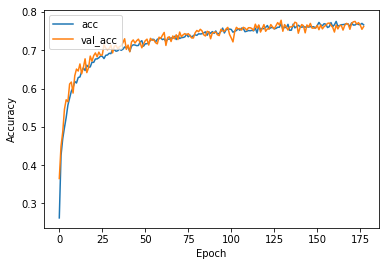

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
 
plt.plot(acc)
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

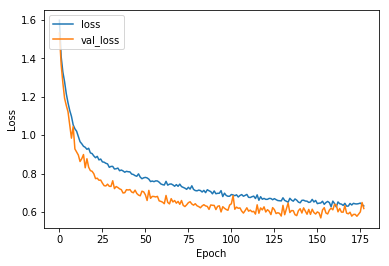

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
 
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [0]:
model.evaluate(X_test, y_test)

972/972 [==============================] - 1s 901us/sample - loss: 0.6255 - acc: 0.7623


[0.6255035718649994, 0.7623457]

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
__________

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=False, to_file='model2.png')

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=False, to_file='model2.png')

In [0]:
# Boilerplate code from sklearn website
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Load Saved Model

In [0]:
from keras.models import load_model
trained_model = tf.keras.models.load_model(saved_h5)
trained_model.evaluate(X_test, y_test)

972/972 [==============================] - 1s 1ms/sample - loss: 0.5751 - acc: 0.7665


[0.5751233136457671, 0.7664609]

## Print out model metrics

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
import itertools

prediction_vector = np.argmax(trained_model.predict(X_test), axis=1)
label_vector = np.argmax(y_test, axis=1)

cm = confusion_matrix(label_vector,prediction_vector)
f1 = f1_score(label_vector,prediction_vector, average='weighted')
kappa = cohen_kappa_score(label_vector,prediction_vector,weights='quadratic')
prec = precision_score(label_vector,prediction_vector, average='weighted')
recll = recall_score(label_vector,prediction_vector, average='weighted')

cm_labels = ['No DR','Mild','Moderate','Severe','Proliferate DR']

print(cm)
print('\nprecision: '+str(prec))
print('\nrecall: '+str(recll))
print('\nf1: '+str(f1))
print('\nkappa: '+str(kappa))

[[270   4   0   0   0]
 [ 12 178  21  18   3]
 [  7   3 129   6   5]
 [  0  24  20 105  26]
 [  1  12  24  41  63]]

precision: 0.7627273659522974

recall: 0.7664609053497943

f1: 0.7596003284893195

kappa: 0.8395937455870504


Confusion matrix, without normalization
[[270   4   0   0   0]
 [ 12 178  21  18   3]
 [  7   3 129   6   5]
 [  0  24  20 105  26]
 [  1  12  24  41  63]]


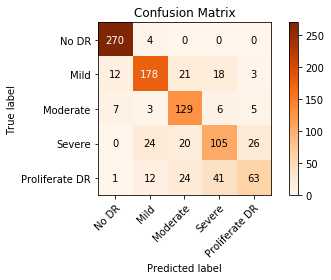

In [0]:
plot_confusion_matrix(label_vector, prediction_vector, cm_labels, title='Confusion Matrix')

Normalized confusion matrix
[[0.98540146 0.01459854 0.         0.         0.        ]
 [0.05172414 0.76724138 0.09051724 0.07758621 0.01293103]
 [0.04666667 0.02       0.86       0.04       0.03333333]
 [0.         0.13714286 0.11428571 0.6        0.14857143]
 [0.0070922  0.08510638 0.17021277 0.29078014 0.44680851]]


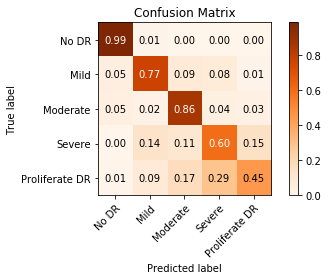

In [0]:
plot_confusion_matrix(label_vector, prediction_vector, cm_labels, normalize=True, title='Confusion Matrix')